##  Transfer Learning
- 예를 들어 강아지와 고양이를 구분하는 딥러닝 모델을 구축하고자 한다.
- 데이터가 100장밖에 없다면 미리 학습해 놓은 Pre_trained model을 가져와 fine tuning 을 시켜야한다.
> 이러한 방법을 Transfer Learning 이라고 한다. == 전이학습

### (1) 일반적인 방법론
- 보통 학습되어 있는 pretrained model은 훨씬 큰 문제를 푸는 모델이기 때문에 output layer를 수정해야 한다.
- 그리고 우리가 보유한 데이터를 input으로 학습을 진행해야한다.
- 일반적으로 pre trained model 의 fc layer는 이전의 weight 는 학습시키지 않는다. == weight freezing이라고 표현
- 다시말해 fc layer 이전에 weight 들은 freezing을 시켜놓고 우리의 데이터를 통해 fc layer 의 weight 만 학습을 시킨다는 말이다.
- 이 과정을 fine tuning 이라고 한다.
- Transfer Learning은 Initialization 의 개념으로도 볼 수 있다. parameter 들의 초기값을 우리는 특정 기법을 쓰는 것이 아닌 Pre_trained model의 가중치들을 사용
- 일반적으로 데이터가 많지 않은 상황에서 보유한 데이터만으로 학습시킨 것보다 전이학습을 한 경우에서 모델 성능이 높고, 학습을 더 빠르게 시킬 수 있다는 장점

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

In [8]:
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'
BATCH_SIZE = 32
EPOCHS = 20

print('torch version : {}'.format(torch.__version__))
print('torch cuda Device : {}'.format(DEVICE))
print('batch_size : {}\nEpochs : {}'.format(BATCH_SIZE,EPOCHS))

torch version : 1.7.1+cu110
torch cuda Device : cuda
batch_size : 32
Epochs : 20


In [17]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ]),
    'val' : transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
    ])
}


# pytorch datasets.ImageFolder 라이브러리를 제공 
# 계층적인 폴더 구조에서 데이터셋을 불러올 때 사용할 수 있다. 
# 각 이미지들이 각 클래스명(class name)을 갖는 폴더 안에 들어가 있는 구조라면, ImageFolder 라이브러리를 이용해 바로 불러올 수 있다.

train_datasets = datasets.ImageFolder("./data/hymenoptera_data",transform = data_transforms['train'])
test_datasets = datasets.ImageFolder("./data/hymenoptera_data",transform = data_transforms['val'])
image_datasets = {x : datasets.ImageFolder("./data/hymenoptera_data",data_transforms[x]) for x in ['train','val']}
dataloader = {x : torch.utils.data.DataLoader(image_datasets[x], batch_size = BATCH_SIZE, num_workers = 0, shuffle = True) for x in ['train','val']}

In [18]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 397
     Root location: ./data/hymenoptera_data
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 397
     Root location: ./data/hymenoptera_data
     StandardTransform
 Transform: Compose(
                CenterCrop(size=(224, 224))
                Resize(size=256, interpolation=PIL.Image.BILINEAR)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            )}

In [37]:
for a,b in dataloader['val']:
    print(a.size())
    print(b.size())
    break

torch.Size([32, 3, 256, 256])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

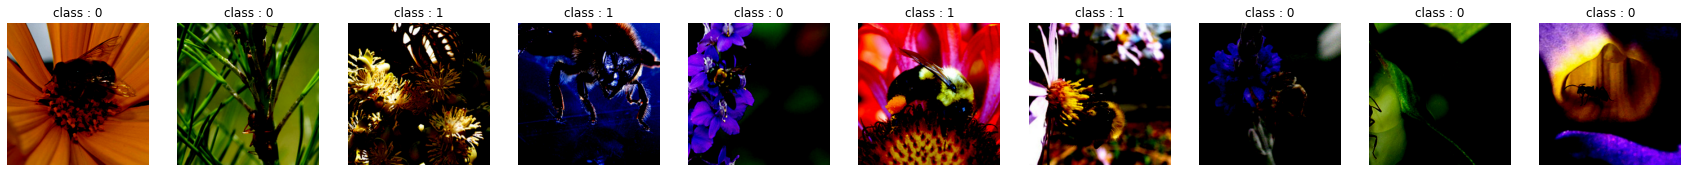

In [38]:
pltsize = 3
plt.figure(figsize = (10*pltsize, pltsize))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(a[i],(1,2,0)))
    plt.title('class : '+ str(b[i].item()))

In [39]:
def train(model, train_loader, optimizer, log_interval):
    model.train()

    for idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)

        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if idx % log_interval == 0:
            print("Train Epoch : {} [{} / {} ({:.6f})]\tTrain Loss : {:.6f}".format(
                Epoch, 
                idx * len(image),
                len(train_loader.dataset), 
                100. * idx / len(train_loader),
                loss.item()))

In [45]:
def evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)

            output = model(image)
            test_loss += criterion(output,label).item()
            prediction = output.max(1,keepdim = True)[1]

            correct += prediction.eq(label.view_as(prediction)).sum().item()
        
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)

        return test_loss, test_accuracy

In [71]:
import torchvision.models as models
model = models.resnet18(pretrained=False).cuda()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.cuda()

In [72]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [73]:
for Epoch in range(1,EPOCHS+1):
    train(model, dataloader['train'],optimizer, log_interval=5)
    test_loss, test_accuracy = evaluate(model, dataloader['val'])
    print('\nEpoch : [{}]\ntest loss : {}\ntest_accuracy : {:.2f}%\n'.format(Epoch,test_loss, test_accuracy))

Train Epoch : 1 [0 / 397 (0.000000)]	Train Loss : 0.710617
Train Epoch : 1 [160 / 397 (38.461538)]	Train Loss : 0.846594
Train Epoch : 1 [320 / 397 (76.923077)]	Train Loss : 0.648990

Epoch : [1]
test loss : 0.022500621281583002
test_accuracy : 56.42%

Train Epoch : 2 [0 / 397 (0.000000)]	Train Loss : 0.543167
Train Epoch : 2 [160 / 397 (38.461538)]	Train Loss : 0.582292
Train Epoch : 2 [320 / 397 (76.923077)]	Train Loss : 0.625196

Epoch : [2]
test loss : 0.022161103165720213
test_accuracy : 59.19%

Train Epoch : 3 [0 / 397 (0.000000)]	Train Loss : 0.636491
Train Epoch : 3 [160 / 397 (38.461538)]	Train Loss : 0.626540
Train Epoch : 3 [320 / 397 (76.923077)]	Train Loss : 0.654590

Epoch : [3]
test loss : 0.022285970392395327
test_accuracy : 61.46%

Train Epoch : 4 [0 / 397 (0.000000)]	Train Loss : 0.659396
Train Epoch : 4 [160 / 397 (38.461538)]	Train Loss : 0.561836
Train Epoch : 4 [320 / 397 (76.923077)]	Train Loss : 0.608824

Epoch : [4]
test loss : 0.02116209298597475
test_accuracy

In [74]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,2)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
criterion = nn.CrossEntropyLoss()

In [75]:
for Epoch in range(1,EPOCHS+1):
    train(model, dataloader['train'],optimizer, log_interval=5)
    test_loss, test_accuracy = evaluate(model, dataloader['val'])
    print('\nEpoch : [{}]\ntest loss : {}\ntest_accuracy : {:.2f}%\n'.format(Epoch,test_loss, test_accuracy))

Train Epoch : 1 [0 / 397 (0.000000)]	Train Loss : 0.747289
Train Epoch : 1 [160 / 397 (38.461538)]	Train Loss : 0.880302
Train Epoch : 1 [320 / 397 (76.923077)]	Train Loss : 0.838872

Epoch : [1]
test loss : 0.020330586871812564
test_accuracy : 66.50%

Train Epoch : 2 [0 / 397 (0.000000)]	Train Loss : 0.672885
Train Epoch : 2 [160 / 397 (38.461538)]	Train Loss : 0.581545
Train Epoch : 2 [320 / 397 (76.923077)]	Train Loss : 0.535968

Epoch : [2]
test loss : 0.017015288849021086
test_accuracy : 78.84%

Train Epoch : 3 [0 / 397 (0.000000)]	Train Loss : 0.579499
Train Epoch : 3 [160 / 397 (38.461538)]	Train Loss : 0.427790
Train Epoch : 3 [320 / 397 (76.923077)]	Train Loss : 0.518706

Epoch : [3]
test loss : 0.014880725808948354
test_accuracy : 80.35%

Train Epoch : 4 [0 / 397 (0.000000)]	Train Loss : 0.444519
Train Epoch : 4 [160 / 397 (38.461538)]	Train Loss : 0.423157
Train Epoch : 4 [320 / 397 (76.923077)]	Train Loss : 0.613699

Epoch : [4]
test loss : 0.01168854846161619
test_accuracy